In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from typing import Literal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import tensorflow as tf
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [2]:

#outDir = os.path.join('output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed = RANDOM_STATE)


EPOCHS =30 # nos of epochs
ALPHA = 0.001 # learning 
TEST_SIZE = 0.2
BATCH_SIZE = 32
PATIENCE = 10
TRAIN_SIZE = int(BATCH_SIZE * 9)

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 150,
          'image.cmap': 'jet',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }
CMAP = 'coolwarm'
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

plt .rcParams.update(params)

<Figure size 1500x800 with 0 Axes>

## Prevent Tensorflow from hogging the memory

In [3]:
# physical_devices = tf.config.list_physical_devices('GPU') # tellme nos of GPUs
# if len (physical_devices) > 0:
#       tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# physical_devices

In [5]:
train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')

In [6]:
train_df.head(),test_df.head()

(   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
 0      2       0       0       0       0       0       0       0       0   
 1      9       0       0       0       0       0       0       0       0   
 2      6       0       0       0       0       0       0       0       5   
 3      0       0       0       0       1       2       0       0       0   
 4      3       0       0       0       0       0       0       0       0   
 
    pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
 0       0  ...         0         0         0         0         0         0   
 1       0  ...         0         0         0         0         0         0   
 2       0  ...         0         0         0        30        43         0   
 3       0  ...         3         0         0         0         0         1   
 4       0  ...         0         0         0         0         0         0   
 
    pixel781  pixel782  pixel783  pixel784  
 0         0   

In [7]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

class_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [8]:
train_df.shape , test_df.shape

((60000, 785), (10000, 785))

In [9]:
train_df['label'].unique()


array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [10]:
test_df['label'].unique()

array([0, 1, 2, 3, 8, 6, 5, 4, 7, 9], dtype=int64)

In [11]:
train_df.max()

label         9
pixel1       16
pixel2       36
pixel3      226
pixel4      164
           ... 
pixel780    255
pixel781    255
pixel782    255
pixel783    255
pixel784    170
Length: 785, dtype: int64

In [12]:
train_df.min()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

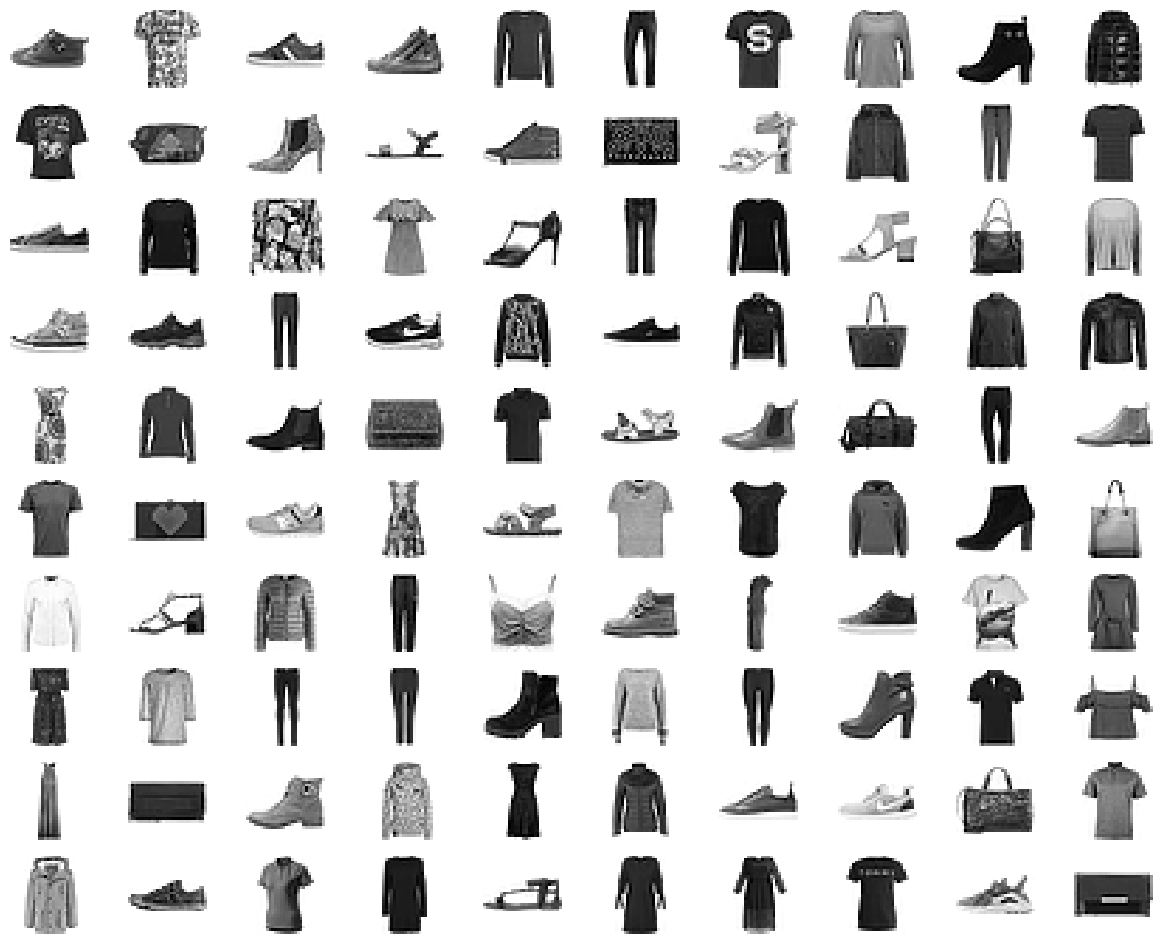

In [13]:
plot_df = train_df.sample(n = 100) # sample 100
fig = plt.figure(figsize = (15,12))
i = 0
for _, row in plot_df.iterrows():
    i += 1

    image = row.values[1:].reshape(28,28)

    ax = fig.add_subplot(10,10,(i),xticks=[],yticks=[])

    ax.imshow(image, cmap=plt.cm.binary)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [15]:
features_df = train_df.drop('label',axis =1)
labels =train_df['label']

In [16]:
labels.value_counts()

label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64

In [17]:
cols = train_df.columns

for col in cols:
    print(f'\nColumns Name: {col} : {train_df[col].unique()}')



Columns Name: label : [2 9 6 0 3 4 5 8 7 1]

Columns Name: pixel1 : [ 0 14  7  3 16  1  4  2]

Columns Name: pixel2 : [ 0  1  3 10  6  2  7  5 16 14 13  9 34 15  4 11 36]

Columns Name: pixel3 : [  0   2   1  10   3   6   4   5   7  56  34  32  16  14  78  25  13   9
   8  52  35  30  23  54 226  15 106]

Columns Name: pixel4 : [  0   1   5   2   3  20  46  87   4  16  12   6  64  36  52  13   7 164
 110  14  92 106 120 105  53  70   9  23  49  25  26  34 121  21  17  10
  41  18  28  80  56 144  22  54  55  50  90 150  19 109  83 132  48  11
  32 145  39  96  15  58   8  68  82 146  86]

Columns Name: pixel5 : [  0   2   4   1   5   3  26  14  39  62  15  16  84   7  88  41  65  17
  35  61  11  21  10   6  18 119 162 106  34  12 217  33  24  37  13 185
  38  71  73   9  40  56  68 171  89  97  91  23  59  42  77 103  29 148
 140  31  45 201   8  95 133  80  44  43  27  20  32  58 123  22 116  66
  60  53 145  85 100  54 210 166 113  19  28 227  30  51  64  96  75  70
  90  82 115 15

In [18]:
train_df.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [20]:
X_train,X_test,y_train,y_test = train_test_split(features_df,labels,
                                                test_size = TEST_SIZE,
                                                stratify = labels,
                                                random_state = RANDOM_STATE)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((48000, 784), (12000, 784), (48000,), (12000,))

In [21]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)


In [22]:
# #l2_reg = tf.keras.regularizers.L2(0.001)
# dor1 = 0.2
# dor2 = 0.3
# dor3 = 0.4
# model = tf.keras.Sequential([
#     ### lAYER 1
#     tf.keras.layers.Dense(350, activation = tf.keras.activations.relu),# kernel_regularizer=l2_reg),

#     #tf.keras.layers.Dropout(dor1, seed = RANDOM_STATE), ## Dropout for layer1
    
#     ### lAYER 2
#     tf.keras.layers.Dense(149, activation = tf.keras.activations.relu),# kernel_regularizer=l2_reg),

#     #tf.keras.layers.Dropout(dor2, seed = RANDOM_STATE), ## Dropout for layer2
#     ### lAYER 3
#     tf.keras.layers.Dense(75, activation = tf.keras.activations.relu),# kernel_regularizer=l2_reg),

#     #tf.keras.layers.Dropout(dor3, seed = RANDOM_STATE), ## Dropout for layer2
    
#     tf.keras.layers.Dense(10) # no activation here
# ])

In [23]:

# model3 = tf.keras.Sequential([
#     ### lAYER 1
#     tf.keras.layers.Dense(350),                                        #, activation = tf.keras.activations.relu),# kernel_regularizer=l2_reg),

#     tf.keras.layers.BatchNormalization(), # Batch
#     tf.keras.layers.ReLU(),
    
#     ### lAYER 2
#     tf.keras.layers.Dense(149),                                        #, activation = tf.keras.activations.relu),# kernel_regularizer=l2_reg),

#     tf.keras.layers.BatchNormalization(), # Batch
#     tf.keras.layers.ReLU(),
   
#     ## lAYER 3
#     tf.keras.layers.Dense(75),                                        #, activation = tf.keras.activations.relu),# kernel_regularizer=l2_reg),

#     tf.keras.layers.BatchNormalization(), # Batch
#     tf.keras.layers.ReLU(),
    
#     tf.keras.layers.Dense(10) # no activation here
# ])

In [24]:
#l2_reg = tf.keras.regularizers.L2(0.001)
dor1 = 0.2
dor2 = 0.3
dor3 = 0.4
model = tf.keras.Sequential([
    ### lAYER 1
    tf.keras.layers.Dense(350, activation = tf.keras.activations.relu),# kernel_regularizer=l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(dor1), ## Dropout for layer1
    
    
    ### lAYER 2
    tf.keras.layers.Dense(149, activation = tf.keras.activations.relu),# kernel_regularizer=l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(dor2), ## Dropout for layer2
    
    
    ### lAYER 3
    tf.keras.layers.Dense(75, activation = tf.keras.activations.relu),# kernel_regularizer=l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(dor3), ## Dropout for layer2
    
    
    tf.keras.layers.Dense(10) # no activation here
])

In [25]:
X_train[:,1].shape

(48000,)

In [26]:
prediction = model(X_train[:1]).numpy()
prediction.sum()

-0.017360896

In [27]:
tf.nn.softmax(prediction).numpy().sum()

1.0

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (1, 350)                    │         274,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (1, 350)                    │           1,400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (1, 350)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 350)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 149)                    │          52,299 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (1, 149)                    │             596 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (1, 149)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 149)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 75)                     │          11,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (1, 75)                     │             300 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (1, 75)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 75)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 10)                     │             760 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 341,355 (1.30 MB)

 Trainable params: 340,207 (1.30 MB)

 Non-trainable params: 1,148 (4.48 KB)

In [29]:
checkpoint_path = ('all_in.weights.h5')

PATIENCE =20
LR_FACTOR = 0.1
LR_PATIENCE = 10
EPOCHS =1000

checkpt_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      verbose=1,
                                                      monitor='val_loss',
                                                      save_best_only=True,
                                                      save_weights_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0,
                                               patience=PATIENCE,
                                               verbose=1,
                                               restore_best_weights=True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=LR_FACTOR,
                                                patience=LR_PATIENCE,
                                                verbose=1)
                                
   


In [30]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True )

In [31]:
y_train[:1].to_numpy().sum()

0

In [32]:
loss_fn(y_train[:1],prediction).numpy()

2.3606575

In [33]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=ALPHA   
)
model.compile(optimizer =optimizer,loss = loss_fn,metrics = ['accuracy'])

### Training our model

In [34]:
history = model.fit(x = X_train,y = y_train,
                     validation_data =[X_test,y_test],
                    callbacks = [checkpt_callback,lr_callback,es_callback],
                     batch_size = BATCH_SIZE,
                     epochs = EPOCHS,verbose = 1)

Epoch 1/1000
1485/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6743 - loss: 1.0075
Epoch 1: val_loss improved from inf to 0.41911, saving model to all_in.weights.h5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6751 - loss: 1.0047 - val_accuracy: 0.8511 - val_loss: 0.4191 - learning_rate: 0.0010
Epoch 2/1000
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8160 - loss: 0.5367
Epoch 2: val_loss improved from 0.41911 to 0.38373, saving model to all_in.weights.h5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8160 - loss: 0.5366 - val_accuracy: 0.8589 - val_loss: 0.3837 - learning_rate: 0.0010
Epoch 3/1000
1475/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8413 - loss: 0.4691
Epoch 3: val_loss improved from 0.38373 to 0.38208, saving model to all_in.weights.h5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8413 - loss: 0.4689 - val_accuracy: 0.8562 - val_loss: 0.3821 - learning_rate: 0.0010
Epoch 4/1000
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [35]:
model.evaluate(X_test,y_test, verbose = 2)

375/375 - 0s - 809us/step - accuracy: 0.9033 - loss: 0.2887


[0.28867292404174805, 0.903333306312561]

In [36]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.754750,0.744583,0.851083,0.419109,0.001
1,0.821063,0.521178,0.858917,0.383726,0.001
2,0.842188,0.460233,0.856167,0.382077,0.001
3,0.850729,0.433731,0.873833,0.344591,0.001
4,0.859250,0.401764,0.876167,0.337242,0.001


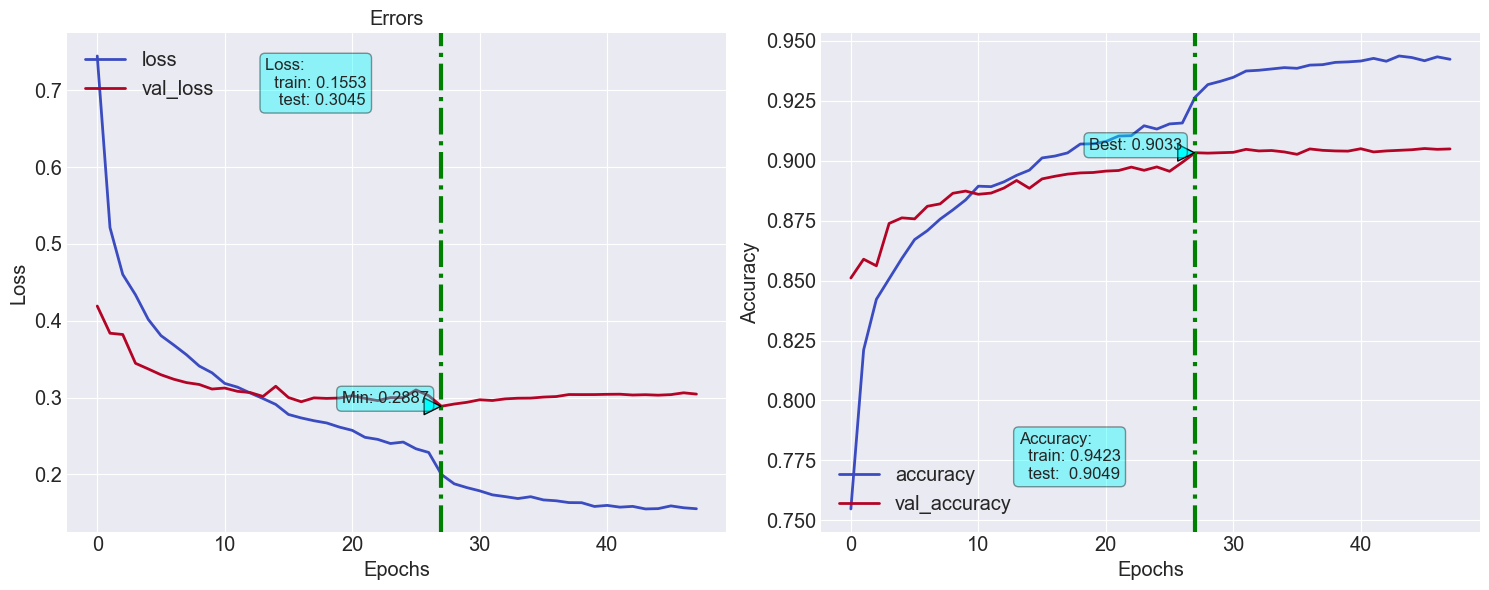

In [37]:
fn_plot_tf_hist(loss_df)

In [60]:
model.load_weights(checkpoint_path)

model.evaluate(X_test,y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.9068 - loss: 0.2827


[0.28867292404174805, 0.903333306312561]

In [38]:
y_logits = model(X_train)
y_pred1 = tf.nn.softmax(y_logits).numpy()

In [39]:
y_pred1

array([[9.4219774e-01, 6.3896528e-09, 1.5573898e-05, ..., 3.7483739e-17,
        2.5299480e-09, 5.0483026e-16],
       [8.6549157e-01, 1.6056564e-06, 1.0293128e-01, ..., 4.8379462e-10,
        2.0308853e-05, 4.1634989e-09],
       [6.3984939e-05, 6.9278528e-08, 9.7075719e-03, ..., 6.2732208e-11,
        3.6479324e-07, 2.9263970e-11],
       ...,
       [6.9402017e-09, 6.0182789e-11, 4.6078977e-03, ..., 3.1921419e-18,
        1.5502750e-11, 4.9949293e-18],
       [3.1862527e-08, 9.9999988e-01, 1.0390065e-08, ..., 9.2441225e-14,
        2.0633108e-11, 6.1164751e-14],
       [6.4304463e-06, 5.0412457e-13, 8.9023153e-05, ..., 3.5617180e-17,
        1.0609047e-10, 5.7001691e-17]], dtype=float32)

In [40]:
pred_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [41]:
y_pred = pred_model(X_train).numpy()
y_pred

array([[9.4219774e-01, 6.3896528e-09, 1.5573898e-05, ..., 3.7483739e-17,
        2.5299480e-09, 5.0483026e-16],
       [8.6549157e-01, 1.6056564e-06, 1.0293128e-01, ..., 4.8379462e-10,
        2.0308853e-05, 4.1634989e-09],
       [6.3984939e-05, 6.9278528e-08, 9.7075719e-03, ..., 6.2732208e-11,
        3.6479324e-07, 2.9263970e-11],
       ...,
       [6.9402017e-09, 6.0182789e-11, 4.6078977e-03, ..., 3.1921419e-18,
        1.5502750e-11, 4.9949293e-18],
       [3.1862527e-08, 9.9999988e-01, 1.0390065e-08, ..., 9.2441225e-14,
        2.0633108e-11, 6.1164751e-14],
       [6.4304463e-06, 5.0412457e-13, 8.9023153e-05, ..., 3.5617180e-17,
        1.0609047e-10, 5.7001691e-17]], dtype=float32)

In [42]:
print(classification_report(y_train, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4800
           1       1.00      1.00      1.00      4800
           2       0.92      0.91      0.92      4800
           3       0.95      0.97      0.96      4800
           4       0.90      0.93      0.91      4800
           5       1.00      1.00      1.00      4800
           6       0.90      0.84      0.87      4800
           7       0.98      0.99      0.99      4800
           8       1.00      1.00      1.00      4800
           9       0.99      0.98      0.99      4800

    accuracy                           0.96     48000
   macro avg       0.96      0.96      0.96     48000
weighted avg       0.96      0.96      0.96     48000



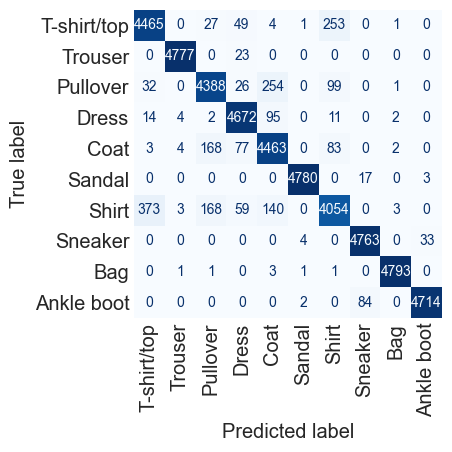

In [43]:
fn_plot_confusion_matrix(y_train, y_pred.argmax(axis=1), class_names)

In [44]:
y_logits = model(X_test)
y_pred2 = tf.nn.softmax(y_logits).numpy()

In [45]:
y_pred2

array([[1.78351139e-10, 2.80018548e-13, 3.62323810e-10, ...,
        2.82037254e-05, 4.81120199e-10, 9.99968171e-01],
       [1.98165304e-11, 4.79050291e-14, 3.35107571e-12, ...,
        9.99980688e-01, 5.52825767e-08, 2.69629868e-06],
       [2.02446350e-12, 3.27229805e-17, 1.51305878e-11, ...,
        4.52903215e-10, 5.60112937e-13, 1.01695409e-10],
       ...,
       [5.25930664e-03, 3.57337512e-06, 5.33049351e-05, ...,
        8.81763498e-08, 9.91570711e-01, 1.04216255e-07],
       [1.34304835e-04, 3.19051696e-06, 2.64867339e-02, ...,
        2.27005392e-09, 5.30503939e-06, 1.44055534e-09],
       [1.46182018e-07, 9.99580774e-09, 2.75014397e-02, ...,
        1.17164664e-14, 3.84352133e-10, 1.75547172e-14]], dtype=float32)

In [46]:
y_pred2 = pred_model(X_test).numpy()
y_pred2

array([[1.78351139e-10, 2.80018548e-13, 3.62323810e-10, ...,
        2.82037254e-05, 4.81120199e-10, 9.99968171e-01],
       [1.98165304e-11, 4.79050291e-14, 3.35107571e-12, ...,
        9.99980688e-01, 5.52825767e-08, 2.69629868e-06],
       [2.02446350e-12, 3.27229805e-17, 1.51305878e-11, ...,
        4.52903215e-10, 5.60112937e-13, 1.01695409e-10],
       ...,
       [5.25930664e-03, 3.57337512e-06, 5.33049351e-05, ...,
        8.81763498e-08, 9.91570711e-01, 1.04216255e-07],
       [1.34304835e-04, 3.19051696e-06, 2.64867339e-02, ...,
        2.27005392e-09, 5.30503939e-06, 1.44055534e-09],
       [1.46182018e-07, 9.99580774e-09, 2.75014397e-02, ...,
        1.17164664e-14, 3.84352133e-10, 1.75547172e-14]], dtype=float32)

In [47]:
print(classification_report(y_test, y_pred2.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1200
           1       0.99      0.98      0.98      1200
           2       0.84      0.85      0.85      1200
           3       0.89      0.91      0.90      1200
           4       0.83      0.86      0.85      1200
           5       0.97      0.97      0.97      1200
           6       0.80      0.70      0.75      1200
           7       0.94      0.96      0.95      1200
           8       0.98      0.98      0.98      1200
           9       0.96      0.94      0.95      1200

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



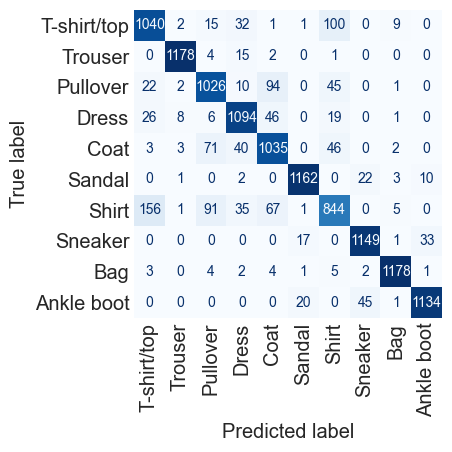

In [48]:
fn_plot_confusion_matrix(y_test, y_pred2.argmax(axis=1), class_names)

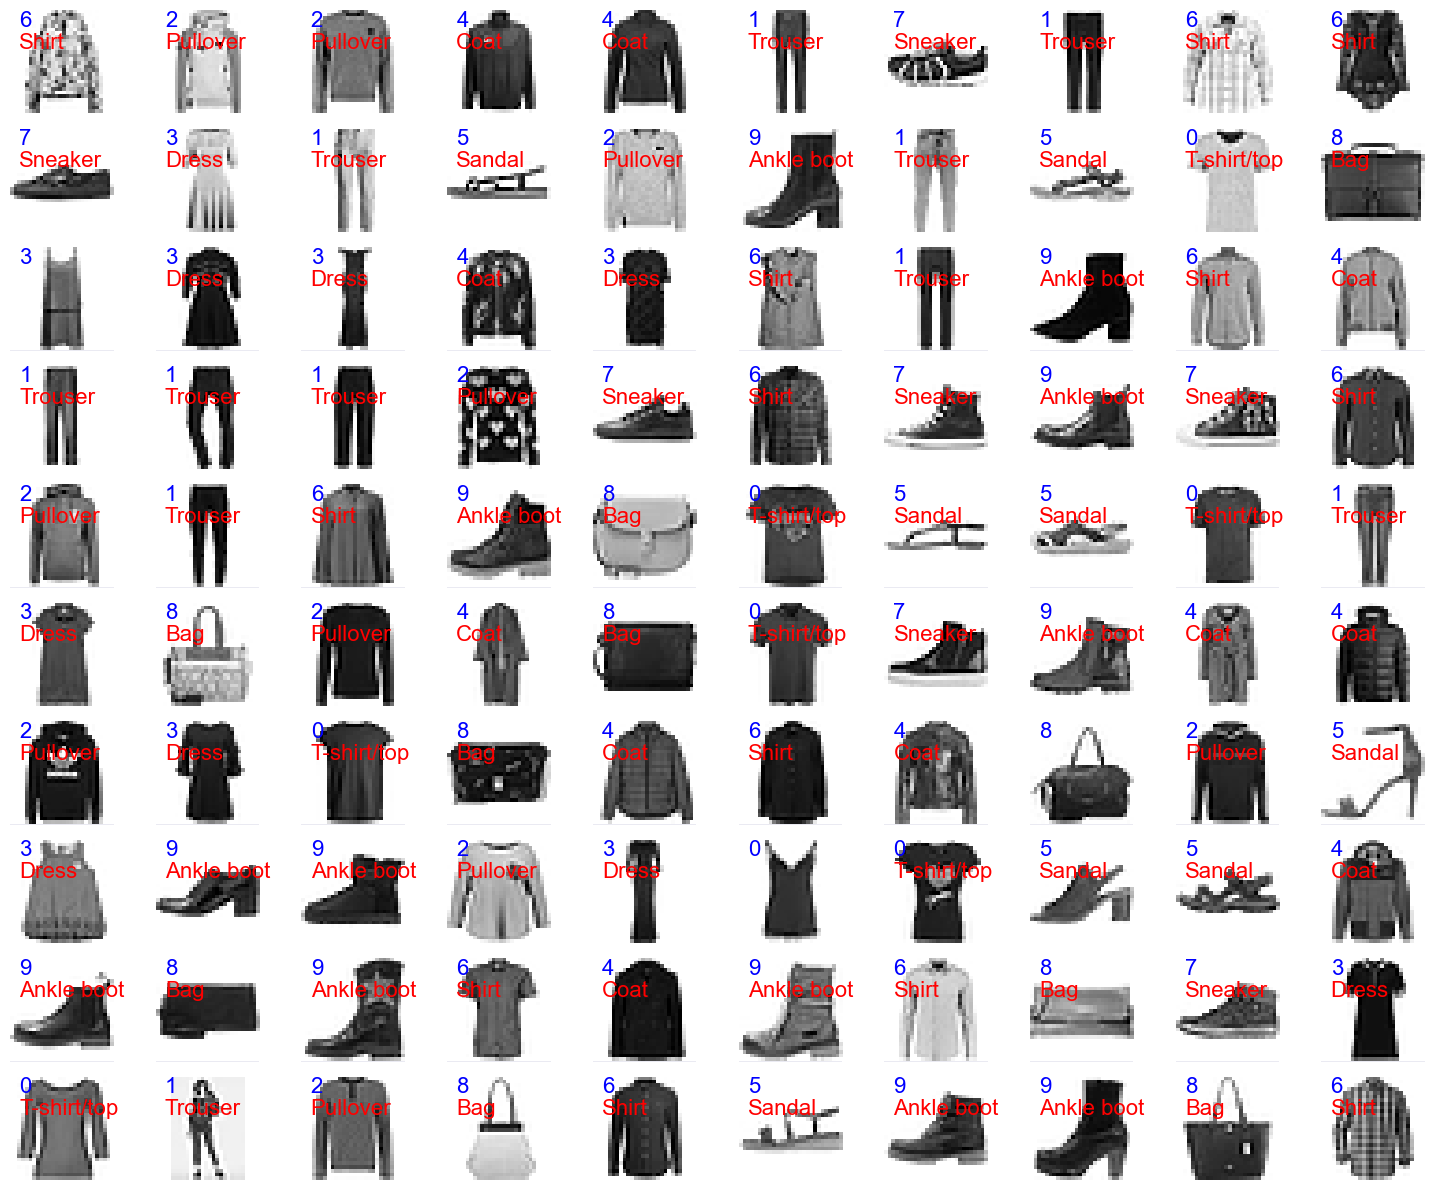

In [50]:
#test_df['pred'] = y_pred
plot_df = train_df.sample(n = 100) # sample 100
fig = plt.figure(figsize = (15,12))
fig.subplots_adjust(left = 0,right = 1,bottom = 0,top = 1,hspace = 0.05,wspace = 0.05)
i = 0
for _, row in plot_df.iterrows():
    i += 1

    image = row.values[1:].reshape(28,28)

    ax = fig.add_subplot(10,10,(i),xticks=[],yticks=[])

    ax.imshow(image, cmap=plt.cm.binary,interpolation = 'nearest')

    ax.text(2,4,str(row.iloc[0]), color = 'b',fontsize = 16)

    color = 'g'

    if row.iloc[0] != row.iloc[100]:
        color = 'r'
        ax.text(2,10,class_names[row.iloc[0]],color = color,fontsize = 16)
        #ax.set_title(class_names[labels])

plt.tight_layout()
plt.show()
    


In [ ]:
# 0.1 ,0.2
#      precision    recall  f1-score   support

#            0       0.94      0.94      0.94      4800
#            1       1.00      1.00      1.00      4800
#            2       0.94      0.93      0.93      4800
#            3       0.97      0.96      0.96      4800
#            4       0.88      0.96      0.92      4800
#            5       1.00      1.00      1.00      4800
#            6       0.93      0.87      0.90      4800
#            7       0.98      0.99      0.99      4800
#            8       1.00      1.00      1.00      4800
#            9       0.99      0.98      0.99      4800

#     accuracy                           0.96     48000
#    macro avg       0.96      0.96      0.96     48000
# weighted avg       0.96      0.96      0.96     48000

# 0.3,0.3,0.3
#               precision    recall  f1-score   support

#            0       0.88      0.90      0.89      4800
#            1       1.00      0.99      0.99      4800
#            2       0.90      0.87      0.89      4800
#            3       0.94      0.93      0.94      4800
#            4       0.85      0.91      0.88      4800
#            5       0.99      0.99      0.99      4800
#            6       0.84      0.80      0.82      4800
#            7       0.97      0.98      0.97      4800
#            8       1.00      0.99      0.99      4800
#            9       0.98      0.97      0.98      4800

#     accuracy                           0.93     48000
#    macro avg       0.94      0.93      0.93     48000
# weighted avg       0.94      0.93      0.93     48000

# 0.2,0.3,0.4
#               precision    recall  f1-score   support

#            0       0.90      0.91      0.90      4800
#            1       1.00      0.99      0.99      4800
#            2       0.90      0.90      0.90      4800
#            3       0.93      0.97      0.95      4800
#            4       0.89      0.88      0.89      4800
#            5       1.00      1.00      1.00      4800
#            6       0.86      0.83      0.84      4800
#            7       0.98      0.98      0.98      4800
#            8       1.00      0.99      1.00      4800
#            9       0.98      0.99      0.98      4800

#     accuracy                           0.94     48000
#    macro avg       0.94      0.94      0.94     48000
# weighted avg       0.94      0.94      0.94     48000

# 0.4,0.3,0.2

#               precision    recall  f1-score   support

#            0       0.89      0.88      0.88      4800
#            1       1.00      0.98      0.99      4800
#            2       0.86      0.89      0.87      4800
#            3       0.92      0.95      0.93      4800
#            4       0.84      0.89      0.86      4800
#            5       0.99      0.98      0.99      4800
#            6       0.83      0.75      0.79      4800
#            7       0.97      0.97      0.97      4800
#            8       1.00      0.99      0.99      4800
#            9       0.97      0.98      0.98      4800

#     accuracy                           0.93     48000
#    macro avg       0.93      0.93      0.93     48000
# weighted avg       0.93      0.93      0.93     48000


# 0.15,0.25,0.35


#               precision    recall  f1-score   support

#            0       0.92      0.92      0.92      4800
#            1       1.00      0.99      0.99      4800
#            2       0.91      0.89      0.90      4800
#            3       0.95      0.95      0.95      4800
#            4       0.86      0.94      0.90      4800
#            5       1.00      1.00      1.00      4800
#            6       0.89      0.82      0.85      4800
#            7       0.98      0.99      0.98      4800
#            8       1.00      1.00      1.00      4800
#            9       0.99      0.98      0.99      4800

#     accuracy                           0.95     48000
#    macro avg       0.95      0.95      0.95     48000
# weighted avg       0.95      0.95      0.95     48000


# 0.25,0.35,0.45
#               precision    recall  f1-score   support

#            0       0.87      0.91      0.89      4800
#            1       1.00      0.99      0.99      4800
#            2       0.88      0.88      0.88      4800
#            3       0.93      0.95      0.94      4800
#            4       0.89      0.87      0.88      4800
#            5       1.00      0.99      0.99      4800
#            6       0.83      0.79      0.81      4800
#            7       0.97      0.98      0.98      4800
#            8       1.00      0.99      0.99      4800
#            9       0.98      0.98      0.98      4800

#     accuracy                           0.93     48000
#    macro avg       0.93      0.93      0.93     48000
# weighted avg       0.93      0.93      0.93     48000

